In [1]:
import sys
import os
import subprocess
import tarfile
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import (random_split, DataLoader, TensorDataset, ConcatDataset)
from torch.distributions.categorical import Categorical

import pytorch_lightning as pl
from pytorch_lightning.metrics import functional
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

import seaborn as sns
from mpl_toolkits import mplot3d
from Bio import motifs
import pickle
import scipy.stats as stats
from torchsummary import summary
from functools import partial

import boda
#from boda.generator.parameters import StraightThroughParameters
#from boda.generator import FastSeqProp, AdaLead
#from boda.generator.plot_tools import matrix_to_dms, ppm_to_IC, ppm_to_pwm

#from boda.model.mpra_basset import MPRA_Basset
from boda.data.mpra_datamodule import MPRA_DataModule
from boda.common import constants, utils
#from boda.generator.energy import BaseEnergy

boda_src = os.path.join( os.path.dirname( os.path.dirname( os.getcwd() ) ), 'src' )
sys.path.insert(0, boda_src)

# from main import unpack_artifact, model_fn
# from pymeme import streme, parse_streme_output

In [2]:
def get_truths_only(datamodule, dataset='val'):
    if dataset=='train':
        data_generator = datamodule.train_dataloader()
    if dataset=='val':
        data_generator = datamodule.val_dataloader()
    if dataset=='test':
        data_generator = datamodule.test_dataloader()
    if dataset=='chr_train':
        data_generator = datamodule.chr_train_dataloader()
    if dataset=='chr_val':
        data_generator = datamodule.chr_val_dataloader()
    if dataset=='chr_test':
        data_generator = datamodule.chr_test_dataloader()
    if dataset=='synth_train':
        data_generator = datamodule.synth_train_dataloader()
    if dataset=='synth_val':
        data_generator = datamodule.synth_val_dataloader()
    if dataset=='synth_test':
        data_generator = datamodule.synth_test_dataloader()

    truths = []
    for local_batch, local_targets in data_generator:
        truths.append(local_targets.numpy())
    truths_array = np.concatenate(truths, axis=0)
    #Unscale:
    if datamodule.rescale is not None:
        a, b = datamodule.rescale
        mins, maxs = datamodule.activity_mins.numpy(), datamodule.activity_maxs.numpy()
        truths_array = (truths_array - a) * (maxs - mins) / (b - a) + mins 
    #Unnormalize:
    if datamodule.normalize:
        stds = datamodule.activity_stds.numpy()
        means = datamodule.activity_means.numpy()
        truths_array = truths_array * stds + means
    return truths_array

def get_predictions(model, datamodule, dataset='val'):
    if dataset=='train':
        data_generator = datamodule.train_dataloader()
    elif dataset=='val':
        data_generator = datamodule.val_dataloader()
    elif dataset=='test':
        data_generator = datamodule.test_dataloader()
    elif dataset=='chr_train':
        data_generator = datamodule.chr_train_dataloader()
    elif dataset=='chr_val':
        data_generator = datamodule.chr_val_dataloader()
    elif dataset=='chr_test':
        data_generator = datamodule.chr_test_dataloader()
    elif dataset=='synth_train':
        data_generator = datamodule.synth_train_dataloader()
    elif dataset=='synth_val':
        data_generator = datamodule.synth_val_dataloader()
    elif dataset=='synth_test':
        data_generator = datamodule.synth_test_dataloader()
    elif dataset=='extra':
        data_generator = datamodule.synth_test_dataloader()
    model.eval()
    truths = []
    preds = []
    if next(model.parameters()).is_cuda:
        for local_batch, local_targets in data_generator:
            preds.append(model(local_batch.cuda()).cpu().detach().numpy())
            truths.append(local_targets.numpy())
    else:
        for local_batch, local_targets in data_generator:
            preds.append(model(local_batch).detach().numpy())
            truths.append(local_targets.numpy())
    preds_array = np.concatenate(preds, axis=0)
    truths_array = np.concatenate(truths, axis=0)
    # #Unscale:
    # if datamodule.rescale is not None:
    #     a, b = datamodule.rescale
    #     mins, maxs = datamodule.activity_mins.numpy(), datamodule.activity_maxs.numpy()
    #     truths_array = (truths_array - a) * (maxs - mins) / (b - a) + mins 
    #     preds_array = (preds_array - a) * (maxs - mins) / (b - a) + mins 
    #Unnormalize:
    if datamodule.normalize:
        stds = datamodule.activity_stds.numpy()
        means = datamodule.activity_means.numpy()
        truths_array = truths_array * stds + means
        preds_array = preds_array * stds + means
    return truths_array, preds_array

def get_scatterplots(truths_array, preds_array, specificity_fn, celltypes=['K562', 'HepG2', 'SKNSH']):
    fig = plt.figure(figsize=(25,6))
    pearsons = []
    spearmans = []
    num_figures = len(celltypes) + 1 
    for dim in range(num_figures - 1):
        plt.subplot(1, num_figures, dim+1)
        pearson = stats.pearsonr(truths_array[:,dim], preds_array[:,dim])[0]
        pearsons.append(pearson)
        spearman = stats.spearmanr(truths_array[:,dim], preds_array[:,dim])[0]
        spearmans.append(spearman)
        sns.scatterplot(x=truths_array[:,dim], y=preds_array[:,dim], color='C'+str(dim), alpha=0.1)
        plt.xlabel('True values')
        plt.ylabel('Predicted values')
        lim_min = min( (truths_array[:,dim]).min(), (preds_array[:,dim]).min() ) - 0.1
        lim_max = max( (truths_array[:,dim]).max(), (preds_array[:,dim]).max() ) + 0.1
        plt.plot([lim_min, lim_max], [lim_min, lim_max], linestyle='dashed', color='gray', alpha=0.75)
        plt.xlim(lim_min, lim_max)
        plt.ylim(lim_min, lim_max)
        plt.gca().set_aspect('equal', adjustable='datalim')
        plt.title(f'{celltypes[dim]} | Spearman {round(spearman, 2)}, Pearson {round(pearson, 2)}')
    plt.subplot(1, num_figures, num_figures)
    specificity_truths = specificity_fn(truths_array)
    specificity_preds = specificity_fn(preds_array)
    specificity_pearson = stats.pearsonr(specificity_truths, specificity_preds)[0]
    specificity_spearman = stats.spearmanr(specificity_truths, specificity_preds)[0]
    sns.scatterplot(x=specificity_truths, y=specificity_preds, color='C6', alpha=0.1)
    lim_min = min( specificity_truths.min(), specificity_preds.min() ) - 0.1
    lim_max = max( specificity_truths.max(), specificity_preds.max() ) + 0.1
    plt.plot([lim_min, lim_max], [lim_min, lim_max], linestyle='dashed', color='gray', alpha=0.75)
    #plt.plot([0, 1], [0, 1], linestyle='dashed', color='gray', alpha=0.75)
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.title(f'Specificity | Spearman {round(specificity_spearman, 2)}, Pearson {round(specificity_pearson, 2)}')
    # plt.xlim(0,1)
    # plt.ylim(0,1)
    plt.draw()
    plt.draw()
    print('')
    print('----------------------------------------------')
    print(f'Pearsons: {pearsons}, average: {round(np.mean(pearsons), 2)}')
    print(f'Spearmans: {spearmans}, average: {round(np.mean(spearmans), 2)}')
    print('----------------------------------------------')

def get_specificity_corr(truths_array, preds_array, specificity_fn):
    fig = plt.figure(figsize=(6,6))
    specificity_truths = specificity_fn(truths_array)
    specificity_preds = specificity_fn(preds_array)
    specificity_pearson = stats.pearsonr(specificity_truths, specificity_preds)[0]
    specificity_spearman = stats.spearmanr(specificity_truths, specificity_preds)[0]
    sns.scatterplot(x=specificity_truths, y=specificity_preds, color='C6')
    lim_min = min( specificity_truths.min(), specificity_preds.min() ) - 0.1
    lim_max = max( specificity_truths.max(), specificity_preds.max() ) + 0.1
    plt.plot([lim_min, lim_max], [lim_min, lim_max], linestyle='dashed', color='gray', alpha=0.75)
    #plt.plot([0, 1], [0, 1], linestyle='dashed', color='gray', alpha=0.75)
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.title(f'Specificity | Spearman {round(specificity_spearman, 2)}, Pearson {round(specificity_pearson, 2)}')
    # plt.xlim(0,1)
    # plt.ylim(0,1)
    plt.draw()
    
def entropy(X):
    p_c = F.softmax(torch.tensor(X, dtype=torch.float64), dim=1).numpy()
    shannon = np.sum(- p_c * np.log(p_c), axis=1)
    return shannon

def align_to_alphabet(in_tensor, in_alphabet=['A','C','G','T'], out_alphabet=constants.STANDARD_NT):
    permuted_idxs = []
    for nt in out_alphabet:
        permuted_idxs.append(in_alphabet.index(nt))
    permutation_idxs = torch.LongTensor(permuted_idxs)
    out_tensor = in_tensor[permutation_idxs, :]
    return out_tensor

def reverse_complement(in_tensor, alphabet=constants.STANDARD_NT):
    rc_dict = {'A':'T', 'G':'C', 'T':'A', 'C':'G'}
    reversed_alphabet = [rc_dict[nt] for nt in alphabet]
    out_tensor = align_to_alphabet(in_tensor, in_alphabet=alphabet,  out_alphabet=reversed_alphabet)
    out_tensor = torch.flip(out_tensor, dims=[1])
    return out_tensor

def single_entropy_score(x, num_classes=3):
    p_c = nn.Softmax(dim=0)(x)
    shannon = torch.sum(- p_c * torch.log(p_c), axis=0)
    return 1 - shannon / np.log(num_classes)

def Pearson_correlation(x, y):
    vx = x - torch.mean(x, dim=0)
    vy = y - torch.mean(y, dim=0)
    pearsons = torch.sum(vx * vy, dim=0).div( (torch.sqrt(torch.sum(vx ** 2, dim=0)) * torch.sqrt(torch.sum(vy ** 2, dim=0))))
    return pearsons, torch.mean(pearsons)

#changed the scale?
def Shannon_entropy(x):
    p_c = nn.Softmax(dim=1)(x)
    #return  - torch.sum(- p_c * torch.log(p_c), axis=1) + 2
    return  torch.sum(- p_c * torch.log(p_c), axis=1)

In [3]:
#! gsutil cp gs://syrgoth/data/MPRA_ALL_HD_v1.txt ./
#! gsutil cp gs://syrgoth/data/MPRA_ALL_HD_v2.txt ./
#! gsutil cp gs://syrgoth/my-model.epoch_5-step_19885.pkl ./

In [4]:
%%time
datamodule = MPRA_DataModule(datafile_path='MPRA_ALL_v3.txt',
                             data_project=['BODA', 'UKBB', 'GTEX'],  #'BODA', 'UKBB', 'GTEX'
                             project_column='data_project',
                             sequence_column='nt_sequence',
                             activity_columns=['K562_mean', 'HepG2_mean', 'SKNSH_mean'],
                             val_chrs=['19','21','X'], #'17','19','21','X' | '11', '15', 'Y'
                             test_chrs =['7', '13'],  #'7', '13' | '4','12'
                             chr_column='chr',
                             std_multiple_cut=3.5,
                             up_cutoff_move=7.0,
                             synth_chr='synth',
                             synth_val_pct=0,
                             synth_test_pct=99.98,
                             synth_seed=0,
                             batch_size=1024,
                             padded_seq_len=600, 
                             num_workers=4,
                             normalize=False,
                             duplication_cutoff=1.4,
                             use_reverse_complements=False)

if not torch.cuda.is_available():
    datamodule.numWorkers = 8

datamodule.setup()

--------------------------------------------------

K562 | top cut value: 11.57, bottom cut value: -3.57
HepG2 | top cut value: 11.08, bottom cut value: -3.16
SKNSH | top cut value: 11.45, bottom cut value: -3.62

Number of examples discarded from top: 0
Number of examples discarded from bottom: 212

Number of examples available: 792429

--------------------------------------------------

Padding sequences...
Tokenizing sequences...
Creating train/val/test datasets...
--------------------------------------------------

Number of examples in train: 781019 (98.56%)
Number of examples in val:   60890 (7.68%)
Number of examples in test:  79627 (10.05%)

Excluded from train: -129107 (-16.29)%
--------------------------------------------------
CPU times: user 3min 1s, sys: 12 s, total: 3min 13s
Wall time: 3min 9s


In [8]:
def get_padding(kernel_size):
    left = (kernel_size - 1) // 2
    right= kernel_size - 1 - left
    return [ max(0,x) for x in [left,right] ]

class Conv1dNorm(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, 
                 stride=1, padding=0, dilation=1, groups=1, 
                 bias=True, batch_norm=True, weight_norm=True):
        super(Conv1dNorm, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, 
                              stride, padding, dilation, groups, bias)
        if weight_norm:
            self.conv = nn.utils.weight_norm(self.conv)
        if batch_norm:
            self.bn_layer = nn.BatchNorm1d(out_channels, eps=1e-05, momentum=0.1, 
                                           affine=True, track_running_stats=True)
    def forward(self, input):
        try:
            return self.bn_layer( self.conv( input ) )
        except AttributeError:
            return self.conv( input )
        
class LinearNorm(nn.Module):
    def __init__(self, in_features, out_features, bias=True, 
                 batch_norm=True, weight_norm=True):
        super(LinearNorm, self).__init__()
        self.linear  = nn.Linear(in_features, out_features, bias=True)
        if weight_norm:
            self.linear = nn.utils.weight_norm(self.linear)
        if batch_norm:
            self.bn_layer = nn.BatchNorm1d(out_features, eps=1e-05, momentum=0.1, 
                                           affine=True, track_running_stats=True)
    def forward(self, input):
        try:
            return self.bn_layer( self.linear( input ) )
        except AttributeError:
            return self.linear( input )

# changed first layer?
class Basset(pl.LightningModule):
    
    def __init__(self, input_channels=4, conv1_channels=300, conv1_kernel_size=19, 
                 conv2_channels=200, conv2_kernel_size=11, 
                 conv3_channels=200, conv3_kernel_size=7, 
                 linear1_channels=1000, linear2_channels=1000, 
                 n_outputs=280, activation='ReLU', 
                 dropout_p=0.3, use_batch_norm=True, use_weight_norm=False,
                 learning_rate=1e-4):                                                
        super().__init__()
        
        self.input_channels    = input_channels
        self.conv1_channels    = conv1_channels
        self.conv1_kernel_size = conv1_kernel_size
        self.conv1_pad         = get_padding(conv1_kernel_size)
        
        self.conv2_channels    = conv2_channels
        self.conv2_kernel_size = conv2_kernel_size
        self.conv2_pad         = get_padding(conv2_kernel_size)
        
        self.conv3_channels    = conv3_channels
        self.conv3_kernel_size = conv3_kernel_size
        self.conv3_pad         = get_padding(conv3_kernel_size)
        
        self.linear1_channels  = linear1_channels
        self.linear2_channels  = linear2_channels
        self.n_outputs         = n_outputs
        
        self.activation        = activation
        
        self.dropout_p         = dropout_p
        self.use_batch_norm    = use_batch_norm
        self.use_weight_norm   = use_weight_norm
        
        self.learning_rate     = learning_rate
        
        self.pad1  = nn.ConstantPad1d(self.conv1_pad, 0.)
        self.conv1 = Conv1dNorm(self.input_channels, 
                                self.conv1_channels, self.conv1_kernel_size, 
                                stride=1, padding=0, dilation=1, groups=1, 
                                bias=True, 
                                batch_norm=self.use_batch_norm, 
                                weight_norm=self.use_weight_norm)
        self.pad2  = nn.ConstantPad1d(self.conv2_pad, 0.)
        self.conv2 = Conv1dNorm(self.conv1_channels, 
                                self.conv2_channels, self.conv2_kernel_size, 
                                stride=1, padding=0, dilation=1, groups=1, 
                                bias=True, 
                                batch_norm=self.use_batch_norm, 
                                weight_norm=self.use_weight_norm)
        self.pad3  = nn.ConstantPad1d(self.conv3_pad, 0.)
        self.conv3 = Conv1dNorm(self.conv2_channels, 
                                self.conv3_channels, self.conv3_kernel_size, 
                                stride=1, padding=0, dilation=1, groups=1, 
                                bias=True, 
                                batch_norm=self.use_batch_norm, 
                                weight_norm=self.use_weight_norm)
        
        self.pad4 = nn.ConstantPad1d((1,1), 0.)

        self.maxpool_3 = nn.MaxPool1d(3, padding=0)
        self.maxpool_4 = nn.MaxPool1d(4, padding=0)
        
        self.linear1 = LinearNorm(self.conv3_channels*13, self.linear1_channels, 
                                  bias=True, 
                                  batch_norm=self.use_batch_norm, 
                                  weight_norm=self.use_weight_norm)
        self.linear2 = LinearNorm(self.linear1_channels, self.linear2_channels, 
                                  bias=True, 
                                  batch_norm=self.use_batch_norm, 
                                  weight_norm=self.use_weight_norm)
        self.output  = nn.Linear(self.linear2_channels, self.n_outputs)
        
        self.nonlin  = getattr(nn, self.activation)()                             
        
        self.dropout = nn.Dropout(p=self.dropout_p)
        
        self.criterion = nn.CrossEntropyLoss()
        
    def forward(self, x):
        hook = self.nonlin( self.conv1( self.pad1( x ) ) )   #changed the nonlinearity?
        hook = self.maxpool_3( hook )
        hook = self.nonlin( self.conv2( self.pad2( hook ) ) )
        hook = self.maxpool_4( hook )
        hook = self.nonlin( self.conv3( self.pad3( hook ) ) )
        hook = self.maxpool_4( self.pad4( hook ) )        
        hook = torch.flatten( hook, start_dim=1 )
        hook = self.dropout( self.nonlin( self.linear1( hook ) ) )
        hook = self.dropout( self.nonlin( self.linear2( hook ) ) )
        output = self.output( hook )
        return output, hook
        
    def training_step(self, batch, batch_idx):
        x, y   = batch
        logits = self(x)
        loss   = self.criterion(logits, y)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y   = batch
        logits = self(x)
        loss   = self.criterion(logits, y)
        self.log('valid_loss', loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)
    
class MPRA_Basset(pl.LightningModule):
    def __init__(self,
                 basset_weights_path=None,
                 pretrained=True,
                 target_width=3,
                 learning_rate=1e-4,
                 optimizer='Adam',
                 scheduler=False,
                 weight_decay=1e-6,
                 epochs=1,
                 extra_hidden_size = 100,
                 criterion = 'MSELoss',
                 last_activation='Tanh',
                 sneaky_factor=1,
                 dropout=0.0,
                 lstm_hidden_size=20,
                 **kwargs):

        super().__init__()
        self.pretrained = pretrained
        self.basset_weights_path = basset_weights_path
        self.target_width = target_width
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.weight_decay = weight_decay
        self.epochs = epochs
        self.extra_hidden_size = extra_hidden_size
        self.sneaky_factor = sneaky_factor
        self.dropout = dropout
        self.lstm_hidden_size = lstm_hidden_size
        
        self.criterion = getattr(nn, criterion)() #nn.MSELoss()   
        self.last_activation = getattr(nn, last_activation)()
        
        self.basset_net = Basset(input_channels=2*self.lstm_hidden_size)
        if self.pretrained:
            try:
                self.basset_net.load_state_dict(torch.load(self.basset_weights_path))
            except:
                self.basset_net.load_state_dict(torch.load(self.basset_weights_path, map_location=torch.device('cpu')))
        
        self.basset_last_hidden_width = self.basset_net.linear2_channels

        self.output_1 = nn.Sequential(
            nn.Linear(self.basset_last_hidden_width, self.extra_hidden_size),
            self.last_activation,
            nn.Linear(self.extra_hidden_size, 1)
            )
        
        self.output_2 = nn.Sequential(
            nn.Linear(self.basset_last_hidden_width, self.extra_hidden_size),
            self.last_activation,
            nn.Linear(self.extra_hidden_size, 1)
            )
        
        self.output_3 = nn.Sequential(
            nn.Linear(self.basset_last_hidden_width, self.extra_hidden_size),
            self.last_activation,
            nn.Linear(self.extra_hidden_size, 1)
            )       
        
        self.dropout = nn.Dropout(p=self.dropout)
        self.example_input_array = torch.rand(1, 4, 600)

        self.lstm = nn.LSTM(input_size=4, hidden_size=self.lstm_hidden_size, bidirectional=True, num_layers=1, batch_first=True)

    def pass_lstm(self, x):
        hook = x.view(-1, 600, 4)
        hook = self.lstm(hook)[0]
        hook = hook.reshape(-1, 2*self.lstm_hidden_size, 600)
        return hook

    def forward(self, x):
        hook = self.pass_lstm(x)
        _, basset_last_hidden = self.basset_net(hook)
        basset_last_hidden = self.dropout(basset_last_hidden)
        output_1 = self.output_1(basset_last_hidden)
        output_2 = self.output_2(basset_last_hidden)
        output_3 = self.output_3(basset_last_hidden)
        return torch.cat((output_1, output_2, output_3), dim=1)
        
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        shannon_pred, shannon_target = Shannon_entropy(y_pred), Shannon_entropy(y)
        #_, specificity_mean_pearson = Pearson_correlation(shannon_pred, shannon_target)
        loss = self.criterion(y_pred, y) + self.sneaky_factor*self.criterion(shannon_pred, shannon_target)
        #loss = self.criterion(y_pred, y)
        self.log('train_loss', loss, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)
        self.log('val_loss', loss, prog_bar=True)
        return {'loss': loss, 'pred': y_pred, 'target': y}
        
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)
        self.log('test_loss', loss)

    def validation_epoch_end(self, validation_step_outputs):
        preds = torch.cat([out['pred'] for out in validation_step_outputs], dim=0)
        targets = torch.cat([out['target'] for out in validation_step_outputs], dim=0) 
        pearsons, mean_pearson = Pearson_correlation(preds, targets)
        shannon_pred, shannon_target = Shannon_entropy(preds), Shannon_entropy(targets)
        specificity_pearson, specificity_mean_pearson = Pearson_correlation(shannon_pred, shannon_target)
        self.log('Pearson', mean_pearson)
        self.log('Pearson_Shannon', specificity_mean_pearson)
        res_str = '|'
        res_str += ' Prediction correlation: {:.5f} | Specificity correlation: {:.5f} |' \
                    .format(mean_pearson.item(), specificity_mean_pearson.item())
        print(res_str)
        print('-'*len(res_str))
        
    def configure_optimizers(self):
        optimizer = getattr(torch.optim, self.optimizer)(self.parameters(), lr=self.learning_rate,
                                                         weight_decay=self.weight_decay)#, amsgrad=True) #I hard-coded amsgrad for Adam  
        if self.scheduler:
            lr_scheduler = {
                'scheduler' : torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.epochs, eta_min=1e-6),
                'name': 'learning_rate'
                           }
            return [optimizer], [lr_scheduler]
        else:
            return optimizer

In [19]:
last_activation_fn = 'ReLU'
extra_hidden_size = 250
seed = 12

pl.seed_everything(seed)

model = MPRA_Basset(basset_weights_path='my-model.epoch_5-step_19885.pkl',
                    extra_hidden_size = extra_hidden_size,
                    criterion='L1Loss', #'MSELoss', #'L1Loss', #'SmoothL1Loss',
                    last_activation=last_activation_fn,
                    sneaky_factor=2,
                    pretrained=True,
                    lstm_hidden_size=2, 
                    dropout=0.1)
if torch.cuda.is_available():
    model.cuda()
num_gpus = torch.cuda.device_count()
# summary(model, (4, 600))

Global seed set to 12


In [20]:
#-------------------- Train only last layer ------------------------
model.basset_net.freeze()

model.epochs = 25
model.learning_rate = 0.05     #0.05
model.weight_decay = 1e-6      #1e-6
model.scheduler = True         #True
datamodule.batch_size = 2048   #1024

# logger = TensorBoardLogger('model_logs', name='MPRAbasset_logs', log_graph=True)
# lr_monitor = LearningRateMonitor(logging_interval='epoch')
# trainer = pl.Trainer(gpus=num_gpus, max_epochs=model.epochs, progress_bar_refresh_rate=10,
#                      logger=logger, callbacks=[lr_monitor], precision=16)
trainer = pl.Trainer(gpus=num_gpus, max_epochs=model.epochs, progress_bar_refresh_rate=10,
                     precision=16)

trainer.fit(model, datamodule)
trainer.test(ckpt_path=None)


#------------------------ Train all layers ------------------------
model.basset_net.unfreeze()

model.epochs = 50
model.learning_rate = 1e-2   #1e-2
model.weight_decay = 1e-5    #1e-5
model.scheduler = False      #False
datamodule.batch_size = 2048  #1024

# logger = TensorBoardLogger('model_logs', name='ash_logs', log_graph=True) 
# lr_monitor = LearningRateMonitor(logging_interval='step')
# trainer = pl.Trainer(gpus=num_gpus, max_epochs=model.epochs, progress_bar_refresh_rate=10,
#                      logger=logger, callbacks=[lr_monitor], precision=16) 
trainer = pl.Trainer(gpus=num_gpus, max_epochs=model.epochs, progress_bar_refresh_rate=10,
                     precision=16) 

trainer.fit(model, datamodule)
trainer.test(ckpt_path=None)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params | In sizes    | Out sizes                            
-----------------------------------------------------------------------------------------------------
0 | criterion       | L1Loss     | 0      | ?           | ?                                    
1 | last_activation | ReLU       | 0      | [1, 250]    | [1, 250]                             
2 | basset_net      | Basset     | 4.9 M  | [1, 4, 600] | [[1, 280], [1, 1000]]                
3 | output_1        | Sequential | 250 K  | [1, 1000]   | [1, 1]                               
4 | output_2        | Sequential | 250 K  | [1, 1000]   | [1, 1]                               
5 | output_3        | Sequential | 250 K  | [1, 1000]   | [1, 1]                               
6 | dropout         | Dropout    | 0      | [1, 1000]   | [1, 1000]             

Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 12


| Prediction correlation: -0.06075 | Specificity correlation: -0.02423 |
------------------------------------------------------------------------


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.65047 | Specificity correlation: 0.24136 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.66626 | Specificity correlation: 0.24823 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.67229 | Specificity correlation: 0.26082 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.67683 | Specificity correlation: 0.26840 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.67169 | Specificity correlation: 0.22843 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.67644 | Specificity correlation: 0.24812 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.68053 | Specificity correlation: 0.27412 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.67944 | Specificity correlation: 0.25623 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.67948 | Specificity correlation: 0.24827 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.67972 | Specificity correlation: 0.27785 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.68085 | Specificity correlation: 0.24141 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.68326 | Specificity correlation: 0.27788 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.68447 | Specificity correlation: 0.25956 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.67860 | Specificity correlation: 0.26818 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.68352 | Specificity correlation: 0.25521 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.68238 | Specificity correlation: 0.28088 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.68354 | Specificity correlation: 0.28322 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.68362 | Specificity correlation: 0.28721 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.68413 | Specificity correlation: 0.27613 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.68443 | Specificity correlation: 0.27817 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.68353 | Specificity correlation: 0.27799 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.68416 | Specificity correlation: 0.27859 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.68460 | Specificity correlation: 0.28223 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.68445 | Specificity correlation: 0.28158 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


| Prediction correlation: 0.68448 | Specificity correlation: 0.28105 |
----------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params | In sizes    | Out sizes                            
-----------------------------------------------------------------------------------------------------
0 | criterion       | L1Loss     | 0      | ?           | ?                                    
1 | last_activation | ReLU       | 0      | [1, 250]    | [1, 250]                             
2 | basset_net      | Basset     | 4.9 M  | [1, 4, 600] | [[1, 280], [1, 1000]]                
3 | output_1        | Sequential | 250 K  | [1, 1000]   | [1, 1]                               
4 | output_2        | Sequential | 250 K  | [1, 1000]   | [1, 1]                               
5 | output_3        | Sequential | 250 K  | [1, 1000]   | [1, 1]                               
6 | dropout         | Dropout    | 0      | [1, 1000]   | [1, 1000]             

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.611890435218811}
--------------------------------------------------------------------------------


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 12


| Prediction correlation: 0.64276 | Specificity correlation: 0.21633 |
----------------------------------------------------------------------


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.53394 | Specificity correlation: 0.44232 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.46762 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.27607 | Specificity correlation: 0.48480 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.48642 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.28210 | Specificity correlation: 0.49820 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.50826 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.51867 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.51706 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.51178 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.54972 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.51034 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.53124 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.28301 | Specificity correlation: 0.53198 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.54371 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.28598 | Specificity correlation: 0.54356 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.53328 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.28624 | Specificity correlation: 0.54721 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.51084 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.53461 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.53529 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.53610 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.52879 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.52895 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.28645 | Specificity correlation: 0.52617 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.54323 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.54458 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.54955 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.54926 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.28770 | Specificity correlation: 0.56318 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.55920 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.54242 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.55255 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.53355 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.49384 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.28568 | Specificity correlation: 0.54095 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.53426 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.53693 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.54896 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.28737 | Specificity correlation: 0.54870 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.55658 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.53592 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.55346 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.28696 | Specificity correlation: 0.54509 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.28515 | Specificity correlation: 0.54636 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.54830 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.55925 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.28785 | Specificity correlation: 0.54926 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.55485 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.54672 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


| Prediction correlation: 0.00000 | Specificity correlation: 0.54732 |
----------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.4325316548347473}
--------------------------------------------------------------------------------


[{'test_loss': 0.4325316548347473}]


----------------------------------------------
Pearsons: [0.9225306082769964, 0.9193079411570142, 0.916415098672604], average: 0.92
Spearmans: [0.8506124510151623, 0.8663556788516455, 0.8582188468136688], average: 0.86
----------------------------------------------

----------------------------------------------
Pearsons: [0.8685970877398381, 0.8626234138541755, 0.8634660749126144], average: 0.86
Spearmans: [0.7801142270651883, 0.7954822374956821, 0.7942353407715619], average: 0.79
----------------------------------------------

----------------------------------------------
Pearsons: [0.8063235412605592, 0.8026705777075434, 0.7960990470171412], average: 0.8
Spearmans: [0.7389493492682763, 0.7486719264772622, 0.7581755638623242], average: 0.75
----------------------------------------------


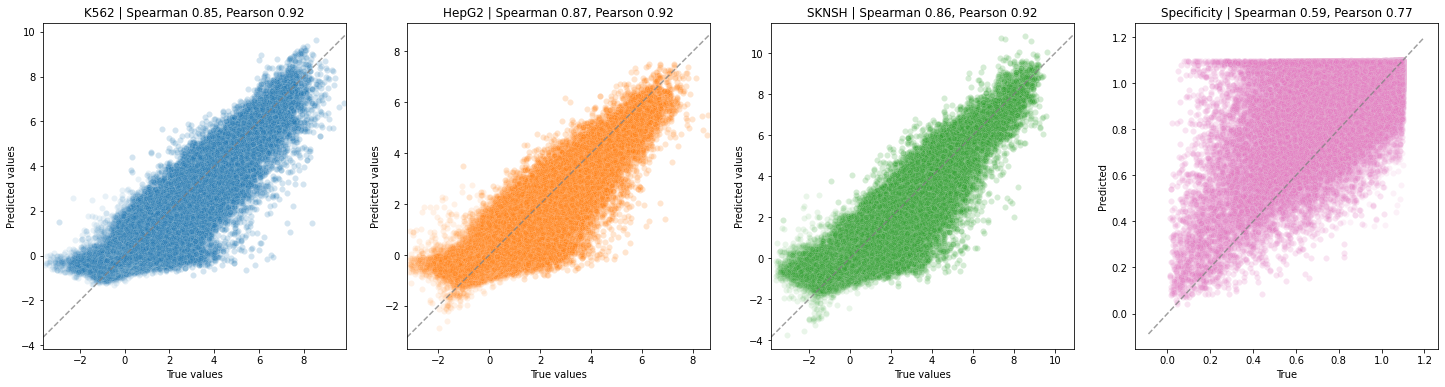

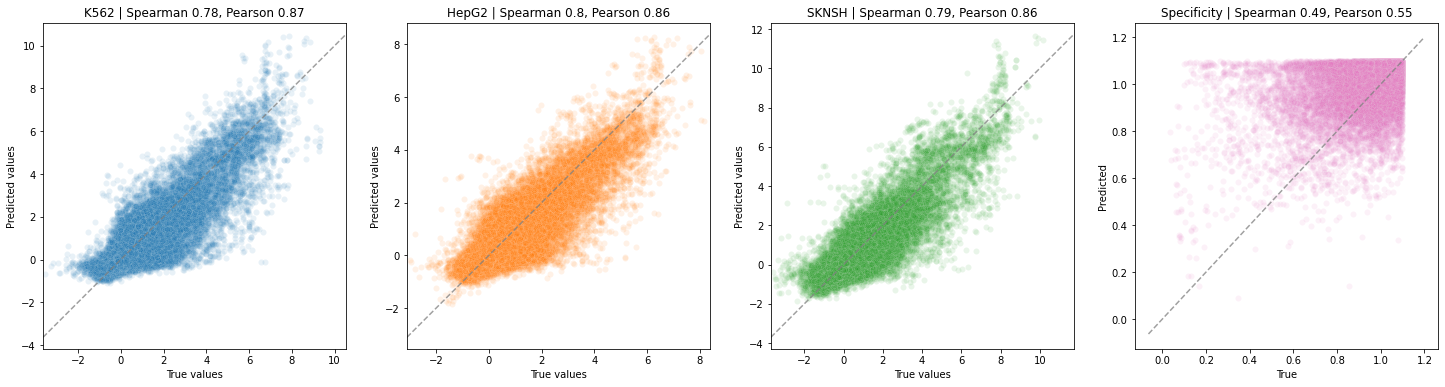

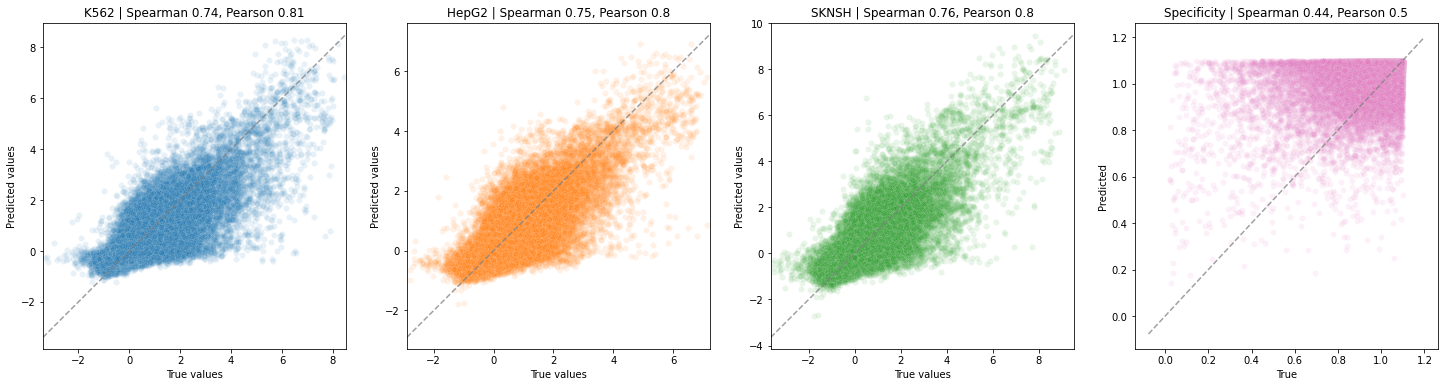

In [21]:
if not next(model.parameters()).is_cuda:
    model.cuda()
model.eval()

train_truths, train_preds = get_predictions(model, datamodule, dataset='train')
val_truths, val_preds = get_predictions(model, datamodule, dataset='val')
test_truths, test_preds = get_predictions(model, datamodule, dataset='test')
get_scatterplots(train_truths, train_preds, specificity_fn=entropy)
get_scatterplots(val_truths, val_preds, specificity_fn=entropy)
get_scatterplots(test_truths, test_preds, specificity_fn=entropy)

In [23]:
#------------------------ Train all layers ------------------------
model.basset_net.unfreeze()

model.epochs = 2
model.learning_rate = 1e-2   #1e-2
model.weight_decay = 1e-5    #1e-5
model.scheduler = False      #False
datamodule.batch_size = 2048  #1024

# logger = TensorBoardLogger('model_logs', name='ash_logs', log_graph=True) 
# lr_monitor = LearningRateMonitor(logging_interval='step')
# trainer = pl.Trainer(gpus=num_gpus, max_epochs=model.epochs, progress_bar_refresh_rate=10,
#                      logger=logger, callbacks=[lr_monitor], precision=16) 
trainer = pl.Trainer(gpus=num_gpus, max_epochs=model.epochs, progress_bar_refresh_rate=10,
                     precision=16) 

trainer.fit(model, datamodule)
trainer.test(ckpt_path=None)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params | In sizes    | Out sizes                            
-----------------------------------------------------------------------------------------------------
0 | criterion       | L1Loss     | 0      | ?           | ?                                    
1 | last_activation | ReLU       | 0      | [1, 250]    | [1, 250]                             
2 | basset_net      | Basset     | 4.9 M  | [1, 4, 600] | [[1, 280], [1, 1000]]                
3 | output_1        | Sequential | 250 K  | [1, 1000]   | [1, 1]                               
4 | output_2        | Sequential | 250 K  | [1, 1000]   | [1, 1]                               
5 | output_3        | Sequential | 250 K  | [1, 1000]   | [1, 1]                               
6 | dropout         | Dropout    | 0      | [1, 1000]   | [1, 1000]             

Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 12


| Prediction correlation: 0.83330 | Specificity correlation: 0.47573 |
----------------------------------------------------------------------


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.28631 | Specificity correlation: 0.52982 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.53467 |
----------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

| Prediction correlation: 0.00000 | Specificity correlation: 0.53454 |
----------------------------------------------------------------------


/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.44762489199638367}
--------------------------------------------------------------------------------


[{'test_loss': 0.44762489199638367}]


----------------------------------------------
Pearsons: [0.923164504598411, 0.9193416287806424, 0.9155422160892864], average: 0.92
Spearmans: [0.8523847130836962, 0.8662377152891656, 0.8590957399427943], average: 0.86
----------------------------------------------

----------------------------------------------
Pearsons: [0.8684313421296715, 0.8616787169001968, 0.8608390163041011], average: 0.86
Spearmans: [0.7790113355137291, 0.7945486286627034, 0.7947058113234859], average: 0.79
----------------------------------------------

----------------------------------------------
Pearsons: [0.8034197176055917, 0.7932959969723049, 0.7862791382370417], average: 0.79
Spearmans: [0.7402638464837603, 0.7424045980584539, 0.7567535740883924], average: 0.75
----------------------------------------------


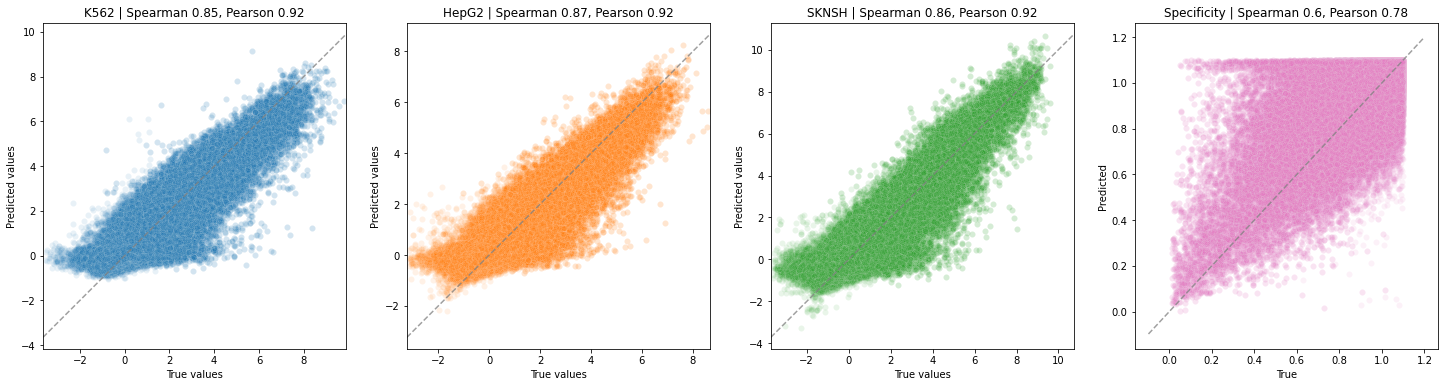

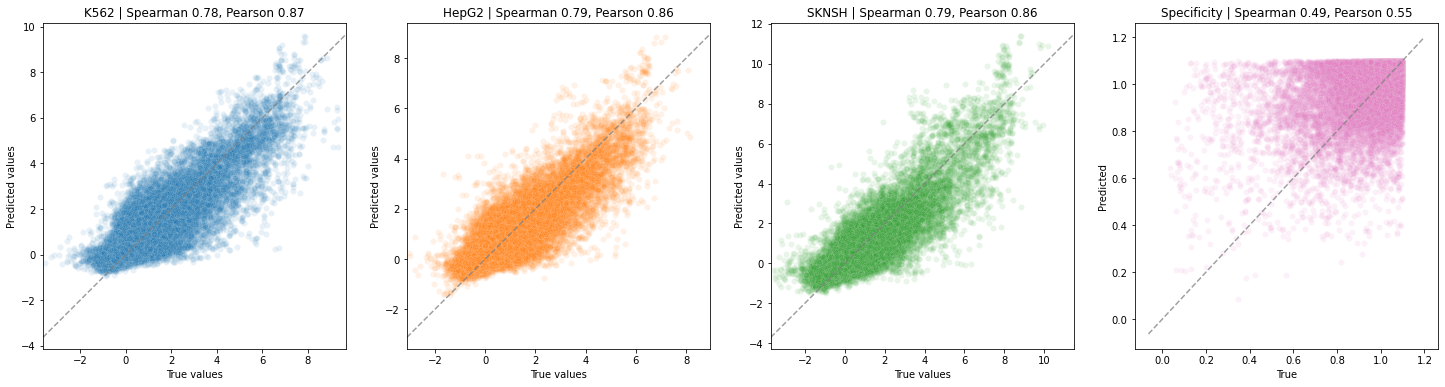

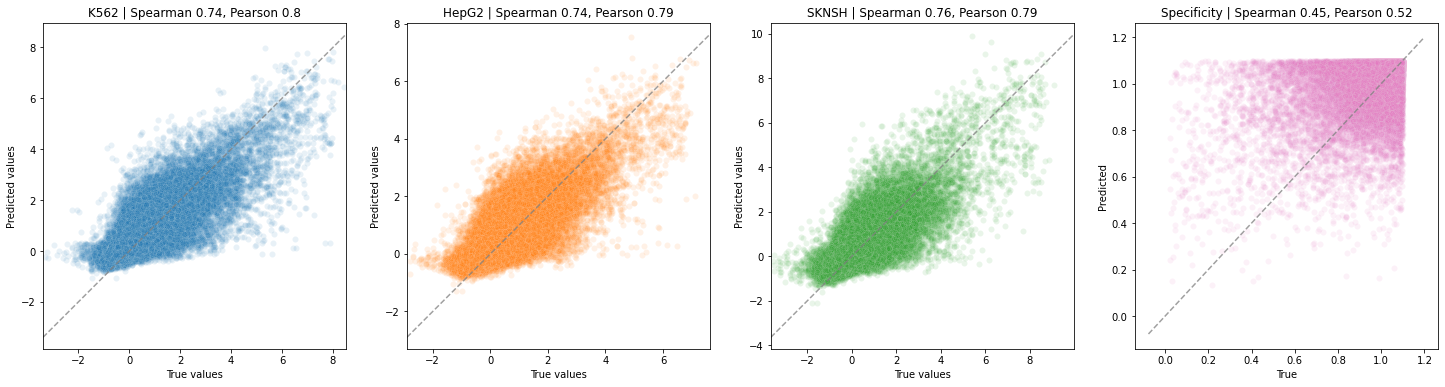

In [24]:
if not next(model.parameters()).is_cuda:
    model.cuda()

train_truths, train_preds = get_predictions(model, datamodule, dataset='train')
val_truths, val_preds = get_predictions(model, datamodule, dataset='val')
test_truths, test_preds = get_predictions(model, datamodule, dataset='test')

get_scatterplots(train_truths, train_preds, specificity_fn=entropy)
get_scatterplots(val_truths, val_preds, specificity_fn=entropy)
get_scatterplots(test_truths, test_preds, specificity_fn=entropy)


----------------------------------------------
Pearsons: [0.8616552127185974, 0.8534652870582027, 0.855421940264988], average: 0.86
Spearmans: [0.76951462179468, 0.7956038655576732, 0.7958903936870415], average: 0.79
----------------------------------------------

----------------------------------------------
Pearsons: [0.8125613393265214, 0.8044162966203154, 0.7854295436363096], average: 0.8
Spearmans: [0.8049092614681134, 0.7870962661474622, 0.7924351688233089], average: 0.79
----------------------------------------------


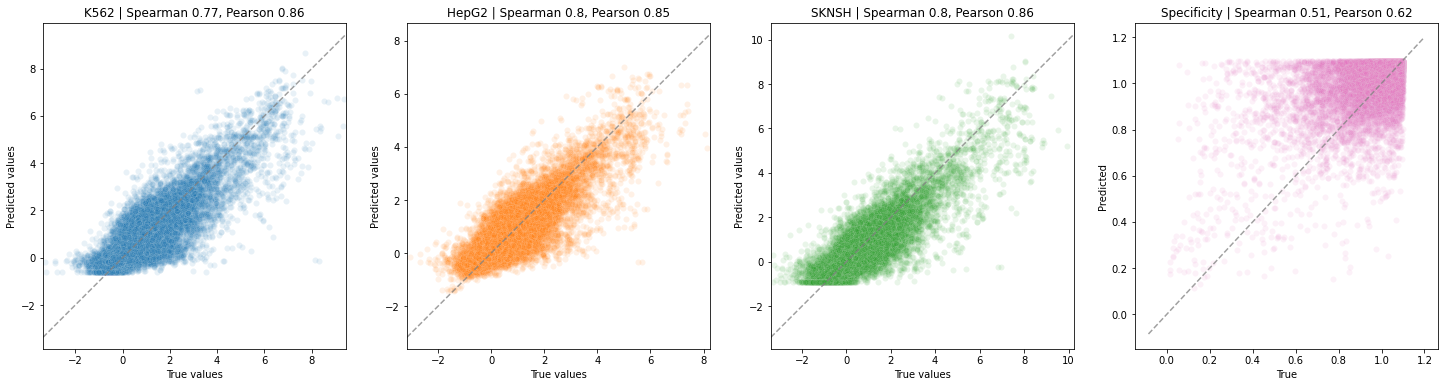

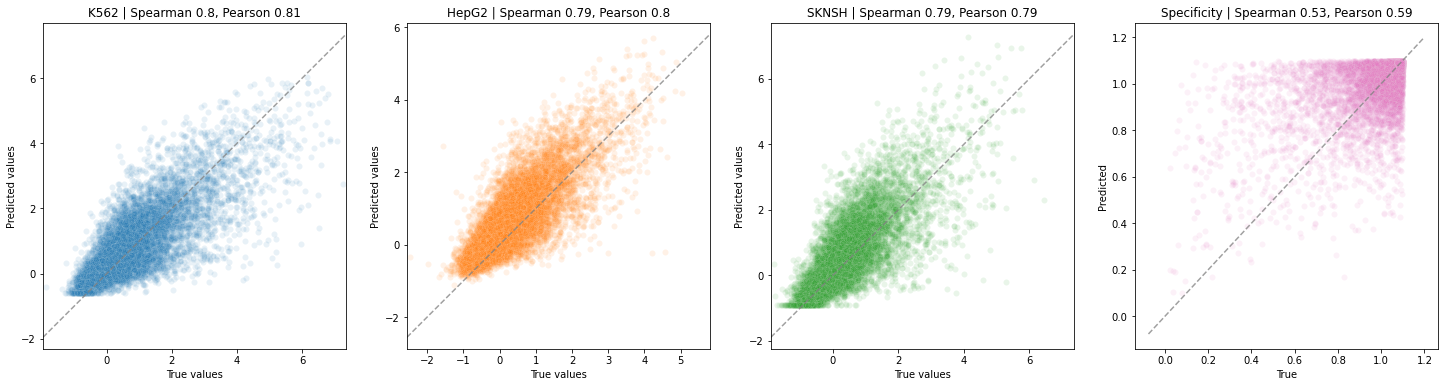

In [10]:
chr_test_truths, chr_test_preds = get_predictions(model, datamodule, dataset='chr_test')
synth_test_truths, synth_test_preds = get_predictions(model, datamodule, dataset='synth_test')
get_scatterplots(chr_test_truths, chr_test_preds, specificity_fn=entropy)
get_scatterplots(synth_test_truths, synth_test_preds, specificity_fn=entropy)

In [11]:
# %load_ext tensorboard
# %tensorboard --logdir model_logs/MPRAbasset_logs

In [12]:
#print(model.extra_hidden_size, model.criterion, model.last_activation, model.sneaky_factor, datamodule.doubling_factor)
name = "manual_checkpoint_"
name = name + f'lasthidden{model.extra_hidden_size}'
#name = name + f'_{model.criterion}'.rstrip('Loss()')
name = name + f'_{model.last_activation}'.rstrip('()')
name = name + f'_sneak{model.sneaky_factor}'
#name = name + f'_double{datamodule.doubling_factor}'
# name += '_ExpAct'
#name += '_' + ''.join(constants.STANDARD_NT)
name += '_noSynth'
name += '_LocusSelect_activity1_4_noHD'
name += '.ckpt'
print(name)

manual_checkpoint_lasthidden250_ReLU_sneak2_noSynth_LocusSelect_activity1_4_noHD.ckpt


In [13]:
trainer.save_checkpoint(name)